# ML Zoomcamp 2023 – Second Capstone Project

This notebook uses the [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs). First run the `make_dataset.py` file to download and extract the raw images.

In [1]:
import os
import re
import subprocess
from pathlib import Path
from time import time
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
try:
    import skimage
    print('Module skimage is installed.')
except ImportError:
    print('Module skimage is not installed, installing it now with pip.')
    p1 = subprocess.run('python -m pip install scikit-image -q', shell=True,
                        check=True, capture_output=True, text=True)
    if p1.stderr:
          print(p1.stderr)
from skimage.io import imread
from skimage.transform import resize

Module skimage is installed.


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img

In [4]:
images_dir = Path.cwd() / 'data/raw/Images'
annotation_dir = Path.cwd() / 'data/raw/Annotation'
processed_dir = Path.cwd() / 'data/processed'

## Data preparation

In [5]:
# folder names come from namimg in raw/Images and raw/Annotation folders
breed_dir_list = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                  'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                  'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                  'n02111129-Leonberg']
breed_dir_list_30 = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                     'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                     'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                     'n02111129-Leonberg', 'n02110806-basenji', 'n02097474-Tibetan_terrier',
                     'n02108000-EntleBucher', 'n02095889-Sealyham_terrier', 'n02096051-Airedale',
                     'n02110958-pug', 'n02091831-Saluki', 'n02095570-Lakeland_terrier', 'n02096177-cairn',
                     'n02086910-papillon', 'n02112137-chow', 'n02091467-Norwegian_elkhound',
                     'n02096294-Australian_terrier', 'n02088364-beagle', 'n02111277-Newfoundland',
                     'n02110185-Siberian_husky', 'n02086646-Blenheim_spaniel', 'n02099601-golden_retriever',
                     'n02099712-Labrador_retriever', 'n02085620-Chihuahua']

In [6]:
# modified from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook
if not processed_dir.exists():
    Path.mkdir(processed_dir, exist_ok=True)
    for breed_dir in breed_dir_list:
        breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
        breed_name = re.sub(r'-', r'_', breed_name.lower())
        Path.mkdir(processed_dir / breed_name, exist_ok=True)
    print(f'''Created {len(os.listdir(processed_dir))} folders to store cropped images of the different breeds.''')
else:
    print(f'Folder {processed_dir} already exists.')

Folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed already exists.


In [7]:
t0 = time()
img_size = 299
print(f'Saving {img_size}x{img_size} image sizes.')
if not list(processed_dir.glob('**/*.jpg')):
    for breed_dir in breed_dir_list:
        counter = 0
        for breed_prefix in os.listdir(f'{annotation_dir}/{breed_dir}'):
            img = Image.open(f'{images_dir}/{breed_dir}/{breed_prefix}.jpg')
            tree = ET.parse(f'{annotation_dir}/{breed_dir}/{breed_prefix}')
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((img_size, img_size))
            breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
            breed_name = re.sub(r'-', r'_', breed_name.lower())
            img.save(str(processed_dir) + '/' + breed_name + '/' + breed_prefix + '.jpg')
            counter += 1
        print(f'Saved {counter} images in {breed_name} folder.')
    print(f'Time elapsed: {round(time()-t0, 0)} seconds.')
else:
    print(f'Folder {str(processed_dir)} with cropped images already exists.')

Saving 299x299 image sizes.
Folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed with cropped images already exists.


### Removal of corrupted images

In [8]:
num_skipped = 0
for folder_name in breed_dir_list:
    folder_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', str(folder_name))
    folder_name = re.sub(r'-', r'_', folder_name.lower())
    breed_dir = processed_dir / folder_name
    print(f'Looking into folder {str(breed_dir)}')
    for fname in os.listdir(breed_dir):
        fpath = breed_dir / fname
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/maltese_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/afghan_hound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/scottish_deerhound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/pomeranian
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/bernese_mountain_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/samoyed
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/irish_wolfhound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/shih_tzu
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/great_pyrenees
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/leonberg
Deleted

## Pre-trained convolutional neural networks

In [9]:
model = Xception(weights='imagenet', input_shape=(img_size, img_size, 3))

In [10]:
path_to_image = 'data/processed/scottish_deerhound/n02092002_109.jpg'
img = load_img(path_to_image, target_size=(img_size, img_size))
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 1s 764ms/step


[[('n02092002', 'Scottish_deerhound', 0.7939882),
  ('n02090721', 'Irish_wolfhound', 0.04308395),
  ('n02090622', 'borzoi', 0.005164045),
  ('n02091244', 'Ibizan_hound', 0.0030015495),
  ('n02100236', 'German_short-haired_pointer', 0.0029592111)]]

## Data generation

In [11]:
new_img_size = 150
image_size_tuple = (new_img_size, new_img_size)
batch_size = 32

In [12]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    processed_dir,
    validation_split = 0.3,
    subset = 'both',
    seed = 33,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = image_size_tuple,
    batch_size = batch_size,
    shuffle=True,
)

Found 2233 files belonging to 10 classes.
Using 1564 files for training.
Using 669 files for validation.


In [13]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((1*val_batches) // 2)
val_ds = val_ds.skip((1*val_batches) // 2)

### Data visualization

In [14]:
names = train_ds.class_names

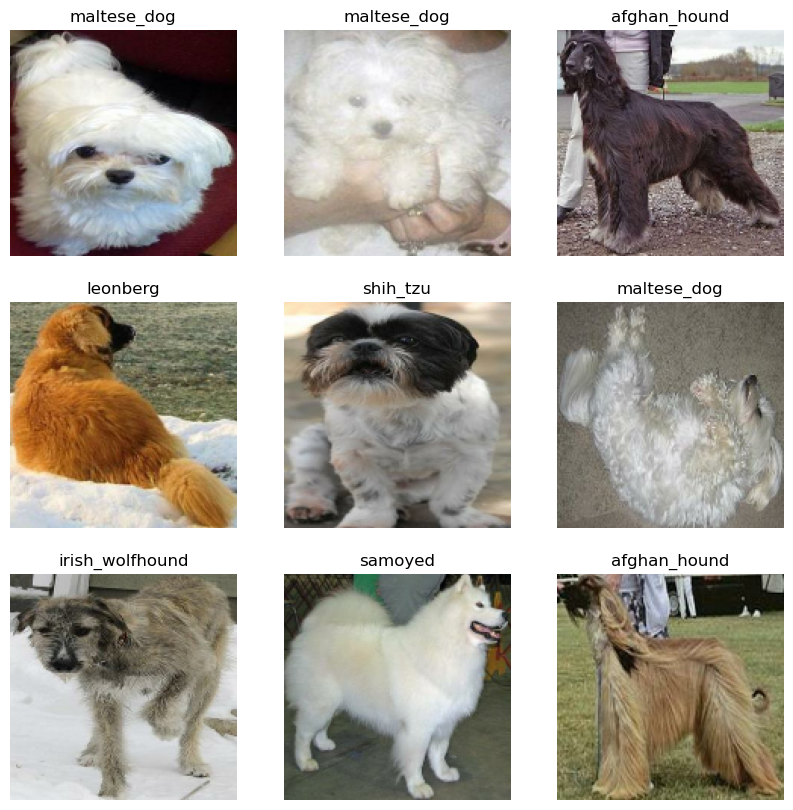

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(names[list(labels[i]).index(1)])
        plt.axis('off')

## Transfer learning

Using a small image size to decrease training time.

In [16]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [17]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [18]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
49/49 [==============================] - 30s 566ms/step - loss: 38.0852 - accuracy: 0.2564 - val_loss: 21.5624 - val_accuracy: 0.2837
Epoch 2/10
49/49 [==============================] - 27s 544ms/step - loss: 15.5707 - accuracy: 0.3593 - val_loss: 12.3013 - val_accuracy: 0.3668
Epoch 3/10
49/49 [==============================] - 27s 542ms/step - loss: 9.6228 - accuracy: 0.4393 - val_loss: 17.8223 - val_accuracy: 0.3123
Epoch 4/10
49/49 [==============================] - 26s 540ms/step - loss: 10.3205 - accuracy: 0.4616 - val_loss: 12.6537 - val_accuracy: 0.3610
Epoch 5/10
49/49 [==============================] - 26s 540ms/step - loss: 9.8709 - accuracy: 0.4795 - val_loss: 17.5387 - val_accuracy: 0.3696
Epoch 6/10
49/49 [==============================] - 26s 541ms/step - loss: 11.9006 - accuracy: 0.4757 - val_loss: 19.2131 - val_accuracy: 0.3152
Epoch 7/10
49/49 [==============================] - 27s 542ms/step - loss: 8.7772 - accuracy: 0.5384 - val_loss: 16.8215 - val_accur

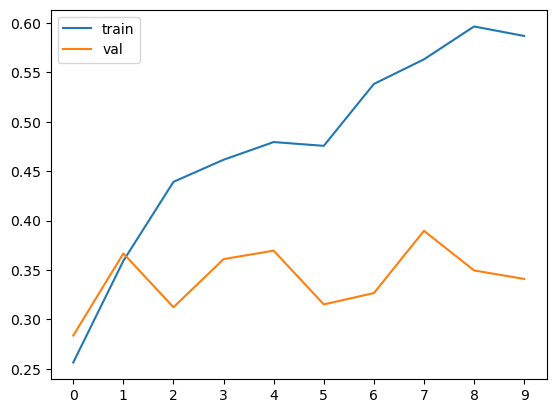

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Data augmentation

In [20]:
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

In [21]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

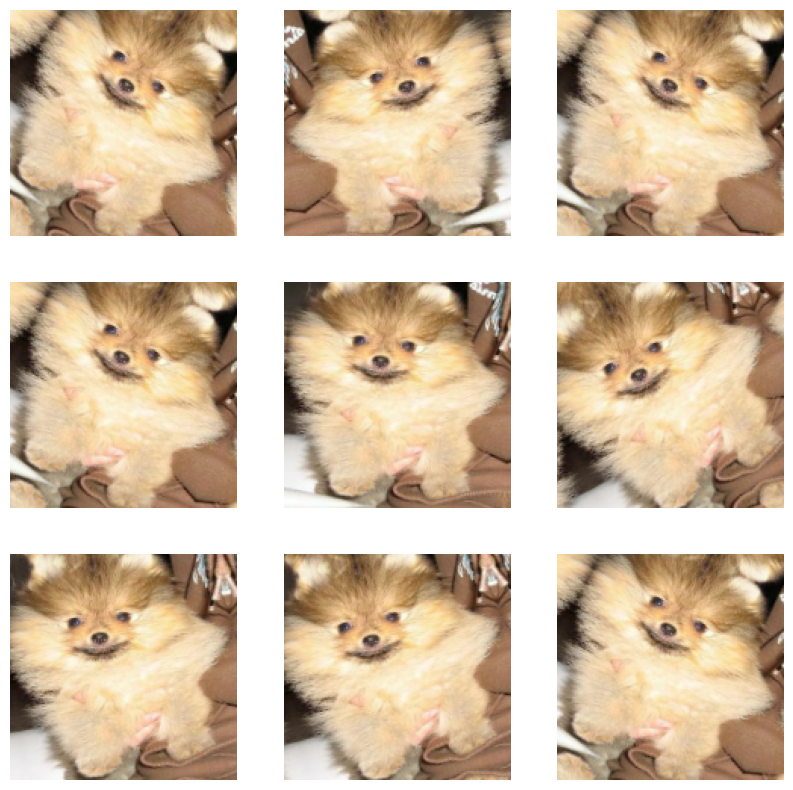

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [23]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
augmented_inputs = data_augmentation(inputs)
scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
base = base_model(scaled_inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [24]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [25]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
49/49 [==============================] - 31s 583ms/step - loss: 0.8700 - accuracy: 0.8165 - val_loss: 0.4409 - val_accuracy: 0.9226
Epoch 2/10
49/49 [==============================] - 28s 566ms/step - loss: 0.5522 - accuracy: 0.8919 - val_loss: 0.2989 - val_accuracy: 0.9398
Epoch 3/10
49/49 [==============================] - 28s 564ms/step - loss: 0.5407 - accuracy: 0.8887 - val_loss: 0.4847 - val_accuracy: 0.9398
Epoch 4/10
49/49 [==============================] - 28s 567ms/step - loss: 0.5886 - accuracy: 0.9022 - val_loss: 0.3519 - val_accuracy: 0.9484
Epoch 5/10
49/49 [==============================] - 28s 569ms/step - loss: 0.5243 - accuracy: 0.9028 - val_loss: 0.4182 - val_accuracy: 0.9484
Epoch 6/10
49/49 [==============================] - 28s 564ms/step - loss: 0.3958 - accuracy: 0.9290 - val_loss: 0.3328 - val_accuracy: 0.9542
Epoch 7/10
49/49 [==============================] - 28s 565ms/step - loss: 0.4562 - accuracy: 0.9156 - val_loss: 0.4590 - val_accuracy: 0.9427

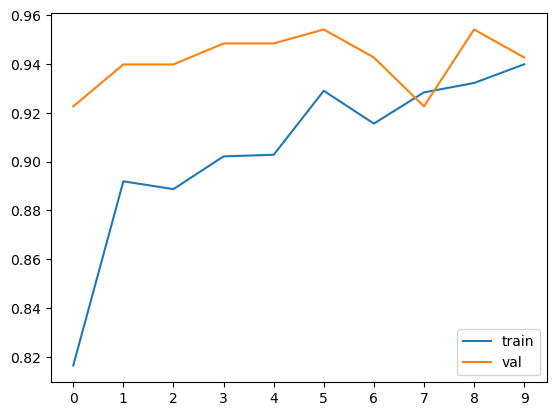

In [26]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Tuning the learning rate

In [27]:
def make_model(learning_rate=0.01):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [28]:
learning_rate_scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f'Learning rate: {lr}')
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    learning_rate_scores[lr] = history.history
    print()
    print('*****'*10)
    print()

Learning rate: 0.0001
Epoch 1/10
49/49 [==============================] - 31s 584ms/step - loss: 1.9156 - accuracy: 0.4086 - val_loss: 1.2544 - val_accuracy: 0.7192
Epoch 2/10
49/49 [==============================] - 28s 563ms/step - loss: 1.0456 - accuracy: 0.7551 - val_loss: 0.6731 - val_accuracy: 0.8768
Epoch 3/10
49/49 [==============================] - 28s 564ms/step - loss: 0.6911 - accuracy: 0.8389 - val_loss: 0.4500 - val_accuracy: 0.9112
Epoch 4/10
49/49 [==============================] - 28s 567ms/step - loss: 0.5334 - accuracy: 0.8676 - val_loss: 0.3523 - val_accuracy: 0.9226
Epoch 5/10
49/49 [==============================] - 28s 567ms/step - loss: 0.4553 - accuracy: 0.8785 - val_loss: 0.2970 - val_accuracy: 0.9226
Epoch 6/10
49/49 [==============================] - 28s 563ms/step - loss: 0.4031 - accuracy: 0.8862 - val_loss: 0.2676 - val_accuracy: 0.9226
Epoch 7/10
49/49 [==============================] - 28s 564ms/step - loss: 0.3863 - accuracy: 0.8926 - val_loss: 0.2452 

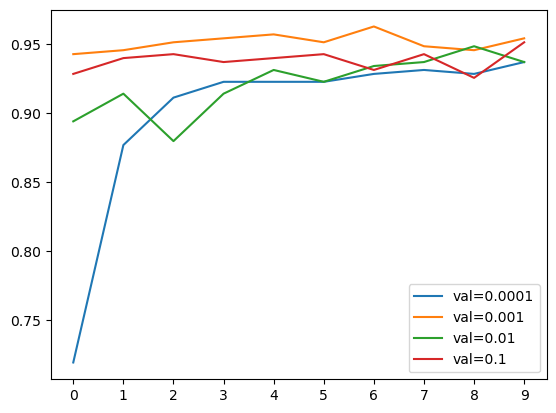

In [29]:
for lr, hist in learning_rate_scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(10))
plt.legend()

## Adjusting inner layers

In [30]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [31]:
best_learning_rate = 0.001
size_scores = {}
for size in [10, 100, 1000]:
    print(f'Inner layer size: {size}')
    model = make_model(learning_rate=best_learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    size_scores[size] = history.history
    print()
    print('*****'*10)
    print()

Inner layer size: 10
Epoch 1/10
49/49 [==============================] - 31s 580ms/step - loss: 1.1118 - accuracy: 0.6311 - val_loss: 0.4659 - val_accuracy: 0.8252
Epoch 2/10
49/49 [==============================] - 28s 565ms/step - loss: 0.5239 - accuracy: 0.8235 - val_loss: 0.2497 - val_accuracy: 0.9312
Epoch 3/10
49/49 [==============================] - 28s 570ms/step - loss: 0.3437 - accuracy: 0.9015 - val_loss: 0.2078 - val_accuracy: 0.9513
Epoch 4/10
49/49 [==============================] - 28s 565ms/step - loss: 0.2984 - accuracy: 0.9098 - val_loss: 0.1938 - val_accuracy: 0.9484
Epoch 5/10
49/49 [==============================] - 28s 567ms/step - loss: 0.2552 - accuracy: 0.9143 - val_loss: 0.1812 - val_accuracy: 0.9542
Epoch 6/10
49/49 [==============================] - 28s 564ms/step - loss: 0.2458 - accuracy: 0.9169 - val_loss: 0.1798 - val_accuracy: 0.9513
Epoch 7/10
49/49 [==============================] - 28s 567ms/step - loss: 0.2523 - accuracy: 0.9226 - val_loss: 0.1701 -

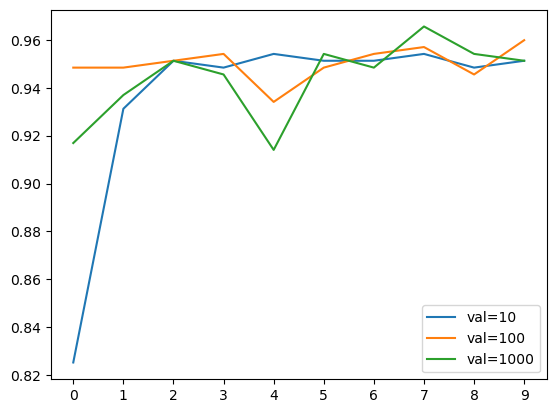

In [32]:
for size, hist in size_scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.xticks(np.arange(10))
plt.legend()

## Adding dropout

In [33]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [34]:
best_learning_rate = 0.001
best_size = 1000
droprate_scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(f'Dropout rate: {droprate}')
    model = make_model(learning_rate=best_learning_rate, size_inner=best_size, droprate=droprate)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    droprate_scores[droprate] = history.history
    print()
    print('*****'*10)
    print()

Dropout rate: 0.0
Epoch 1/30
49/49 [==============================] - 31s 595ms/step - loss: 0.5733 - accuracy: 0.8306 - val_loss: 0.1909 - val_accuracy: 0.9427
Epoch 2/30
49/49 [==============================] - 28s 575ms/step - loss: 0.2981 - accuracy: 0.8939 - val_loss: 0.1754 - val_accuracy: 0.9456
Epoch 3/30
49/49 [==============================] - 28s 573ms/step - loss: 0.2288 - accuracy: 0.9130 - val_loss: 0.2042 - val_accuracy: 0.9427
Epoch 4/30
49/49 [==============================] - 28s 571ms/step - loss: 0.2178 - accuracy: 0.9182 - val_loss: 0.1833 - val_accuracy: 0.9484
Epoch 5/30
49/49 [==============================] - 28s 570ms/step - loss: 0.2071 - accuracy: 0.9246 - val_loss: 0.2085 - val_accuracy: 0.9370
Epoch 6/30
49/49 [==============================] - 28s 571ms/step - loss: 0.1790 - accuracy: 0.9437 - val_loss: 0.1581 - val_accuracy: 0.9542
Epoch 7/30
49/49 [==============================] - 28s 572ms/step - loss: 0.1697 - accuracy: 0.9361 - val_loss: 0.1580 - va

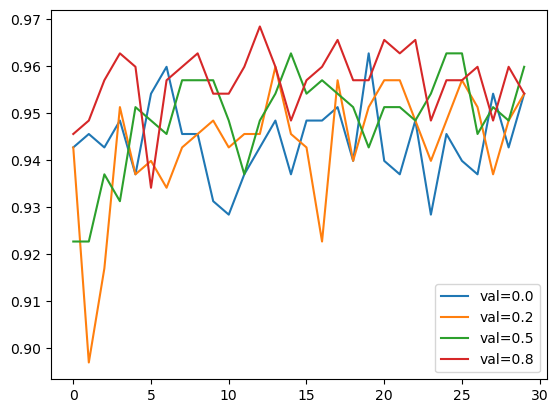

In [35]:
for droprate, hist in droprate_scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
# plt.ylim(0.86, 0.95)
plt.legend(loc=4)

## Saving best model with checkpointing

In [36]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [37]:
learning_rate = 0.001
size = 1000
droprate = 0.8
model = make_model(learning_rate=learning_rate, size_inner=size, droprate=droprate)

In [38]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[checkpoint])

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 0.9406 - accuracy: 0.7442

/opt/saturncloud/envs/saturn/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 31s 590ms/step - loss: 0.9406 - accuracy: 0.7442 - val_loss: 0.2077 - val_accuracy: 0.9370
Epoch 2/50
49/49 [==============================] - 28s 577ms/step - loss: 0.6039 - accuracy: 0.8254 - val_loss: 0.1755 - val_accuracy: 0.9484
Epoch 3/50
49/49 [==============================] - 28s 576ms/step - loss: 0.4649 - accuracy: 0.8638 - val_loss: 0.1559 - val_accuracy: 0.9542
Epoch 4/50
49/49 [==============================] - 28s 579ms/step - loss: 0.4396 - accuracy: 0.8657 - val_loss: 0.1691 - val_accuracy: 0.9628
Epoch 5/50
49/49 [==============================] - 28s 574ms/step - loss: 0.4989 - accuracy: 0.8446 - val_loss: 0.1898 - val_accuracy: 0.9427
Epoch 6/50
49/49 [==============================] - 28s 572ms/step - loss: 0.4154 - accuracy: 0.8734 - val_loss: 0.1613 - val_accuracy: 0.9570
Epoch 7/50
49/49 [==============================] - 28s 572ms/step - loss: 0.3809 - accuracy: 0.8728 - val_loss: 0.1626 - val_accuracy: 0.9513
Epoch 8/50

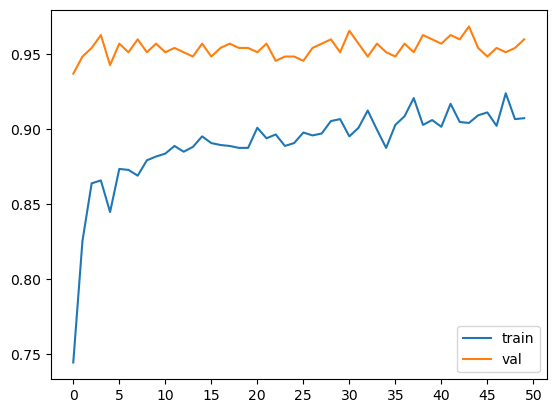

In [39]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.linspace(0, 50, 11))
plt.legend()

## Testing the model

In [40]:
best_model = keras.models.load_model('xception_v1_48_0.968.h5')

In [41]:
loss, test_acc = best_model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

10/10 [==============================] - 5s 439ms/step - loss: 0.2034 - accuracy: 0.9219
Test accuracy: 0.9219


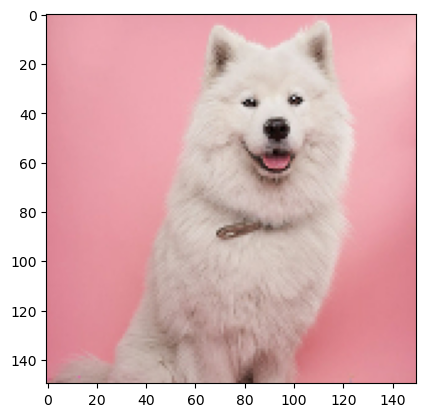

In [42]:
path_to_image = '/home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/test/samoyed.jpg'
img = keras.utils.load_img(path_to_image, target_size=image_size_tuple)
plt.imshow(img)

In [43]:
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

In [44]:
predictions = best_model.predict(img_array)

1/1 [==============================] - 1s 651ms/step


In [45]:
dict(zip(names, predictions[0]))

{'afghan_hound': -9.772487,
 'bernese_mountain_dog': -11.13333,
 'great_pyrenees': 2.7572303,
 'irish_wolfhound': -7.651988,
 'leonberg': -13.140571,
 'maltese_dog': -4.0290384,
 'pomeranian': 4.278456,
 'samoyed': 14.394495,
 'scottish_deerhound': -8.150183,
 'shih_tzu': -9.964146}